In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Dropout, Layer, Activation, Reshape, Permute
from keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam
import random

#from helper import *
#from segnet_model import *

from distutils.version import LooseVersion

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

Using TensorFlow backend.


TensorFlow Version: 1.0.0


In [2]:
from tqdm import tqdm
from os.path import isfile, isdir
from urllib.request import urlretrieve
import tarfile
import zipfile
import os

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

def download_data():
    image_data = "lyft_training_data.tar.gz"
    image_data2 = "calra-capture-20180528.zip"

    if not isdir("Train"): 
        if not isfile(image_data):
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc='image data') as pbar:
                urlretrieve(
                    'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/Lyft_Challenge/Training+Data/lyft_training_data.tar.gz',
                    image_data,
                    pbar.hook)
        if not isfile(image_data2):
            with DLProgress(unit='B', unit_scale=True, miniters=1, desc='image data') as pbar:
                urlretrieve(
                    'https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180528.zip',
                    image_data2,
                    pbar.hook)

        targz = tarfile.open(image_data, 'r')
        targz.extractall()
        targz.close()

        zipdata = zipfile.ZipFile(image_data2, 'r')
        zipdata.extractall("Train")
        zipdata.close()

In [3]:
download_data()

image data: 608MB [01:58, 6.80MB/s]                               
image data: 576MB [01:27, 6.57MB/s]                               


In [5]:
import h5py
from keras.models import load_model
from keras import __version__ as keras_version

model_file = 'basic2/model_with_weight.h5'
#model_file = 'full/model_with_weight.h5'
f = h5py.File(model_file, mode='r')
model_version = f.attrs.get('keras_version')

keras_version = str(keras_version).encode('utf8')

if model_version != keras_version:
    print('You are using Keras version ', keras_version,
          ', but the model was built using ', model_version)

model = load_model(model_file)

You are using Keras version  b'2.0.6' , but the model was built using  b'2.1.3'


In [6]:
width = 800
top = 220
bottom = 540
height = bottom - top
classes = 3

def normalized(rgb):
    if len(rgb.shape) != 3:
        raise RuntimeError('normalized: input data is not 3 dimensional data')

    if rgb.shape[2] != 3:
        raise RuntimeError('normalized: input data is not in RGB color')
        
    n_image = rgb[top:bottom,:,:]
    norm=np.zeros((n_image.shape[0], n_image.shape[1], 3), np.float32)
    norm[:,:,0]=cv2.equalizeHist(n_image[:,:,0])
    norm[:,:,1]=cv2.equalizeHist(n_image[:,:,1])
    norm[:,:,2]=cv2.equalizeHist(n_image[:,:,2])

    return norm

In [7]:
def DisplayImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2[:,:,0])
    ax2.set_title(title2, fontsize=10)

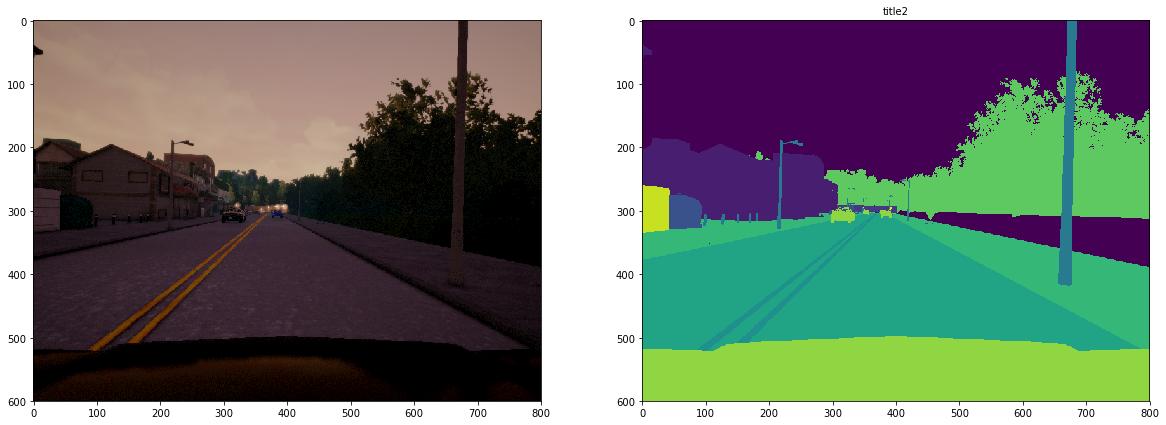

In [21]:
#Filename = '478.png'
Filename = '566.png'
img=cv2.cvtColor(cv2.imread ('Train/CameraRGB/' + Filename), cv2.COLOR_BGR2RGB)
img2=cv2.cvtColor(cv2.imread ('Train/CameraSeg/' + Filename), cv2.COLOR_BGR2RGB)
#hot = one_hot_encode(img2[:,:,0])
DisplayImage(img, img2, '', 'title2')


In [22]:
image_array = np.asarray(normalized(img))
prediction = model.predict(image_array[None, :, :, :], batch_size=1)

def getroad(predict):
    tmp = np.reshape(np.where(prediction[0,:,1] > 0.5, 1, 0), (height, width)).astype(np.int8)
    road = np.zeros(shape=(600, 800)).astype(np.int8)
    road[top:bottom,:]=tmp
    road[:250,:] = 0
    
    return road

def getcars(predict):
    tmp = np.reshape(np.where(prediction[0,:,2] > 0.5, 1, 0), (height, width)).astype(np.int8)
    car = np.zeros(shape=(600, 800)).astype(np.int8)
    car[top:bottom,:]=tmp
    car[:230,:] = 0
    return car

road = getroad(prediction)
cars = getcars(prediction)

(600, 800)
int8


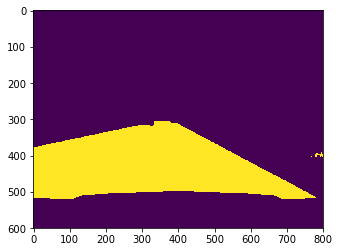

In [23]:
plt.imshow(road)
print(road.shape)
print(road.dtype)

(600, 800)
int8


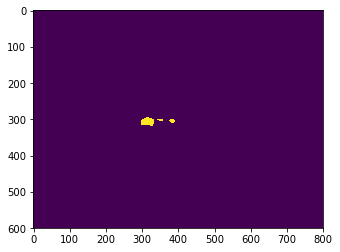

In [24]:
plt.imshow(cars)
print (cars.shape)
print (cars.dtype)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Layer)              (None, 320, 800, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 322, 802, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 320, 800, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 320, 800, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 320, 800, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 160, 400, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 162, 402, 64)      0         
__________